In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
import matplotlib as mpl
import re
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score 
import os

# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18


In [4]:

def spearman_correlation_by_classification(data: pd.DataFrame, metric1: str, metric2: str):
    """
    Compute the Spearman rank correlation coefficient and p-value for two subsets of data defined by classification.
    
    The data is split into two groups:
      - Group "B": where Classification is exactly "B".
      - Group "LSW/HSW": where Classification is either "LSW" or "HSW".
    
    Parameters:
        data (pd.DataFrame): The DataFrame containing your dataset.
        metric1 (str): The name of the first metric (column) in the DataFrame.
        metric2 (str): The name of the second metric (column) in the DataFrame.
        
    Returns:
        dict: A dictionary with keys "B" and "LSW/HSW". Each key maps to a tuple (rho, p_value)
              where rho is the Spearman correlation coefficient and p_value is the corresponding p-value.
    """
    # Check if required columns are present
    required_cols = {metric1, metric2, "Classification"}
    missing = required_cols - set(data.columns)
    if missing:
        raise ValueError(f"Missing required columns in DataFrame: {missing}")

    # Split data into two subsets:
    # Subset for Classification "B"
    subset_B = data[data["Classification"] == "B"]
    # Subset for Classification either "LSW" or "HSW"
    subset_LSW_HSW = data[data["Classification"].isin(["LSW", "HSW"])]

    # Function to compute Spearman correlation, dropping missing values
    def compute_corr(df_subset: pd.DataFrame):
        df_clean = df_subset[[metric1, metric2]].dropna()
        return spearmanr(df_clean[metric1], df_clean[metric2])
    
    # Calculate the correlations for each group
    results = {}
    results["B"] = compute_corr(subset_B)
    results["LSW/HSW"] = compute_corr(subset_LSW_HSW)
    
    return results



In [20]:

# Example usage:
if __name__ == "__main__":
    # Replace the file path with your actual CSV file location.
    file_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        exit(1)
    
    # Define the two metrics you want to compare (update with actual column names from your CSV).
    metric_a = "CB/Aw"  # Replace with your actual column name for metric 1
    metric_b = "dim_Q"  # Replace with your actual column name for metric 2
    
    try:
        results = spearman_correlation_by_classification(df, metric_a, metric_b)
        for group, (rho, p_value) in results.items():
            print(f"Group '{group}': Spearman rho = {rho}, p-value = {p_value}")
    except ValueError as ve:
        print(ve)

Group 'B': Spearman rho = -0.5995872033023736, p-value = 0.008536698768223001
Group 'LSW/HSW': Spearman rho = -0.08659984542422673, p-value = 0.447927414929301


In [5]:
import os
import glob

def count_folders_with_reprojected_gpkg(base_path):
    """
    Count the number of sub-folders in base_path that contain at least one GeoPackage (.gpkg) file 
    ending with '_reprojected.gpkg'.
    
    Parameters:
        base_path (str): The path to the directory containing the river folders.
    
    Returns:
        int: Number of folders that have the _reprojected.gpkg file.
    """
    count = 0
    # List all items in the base_path and filter for directories
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            # Use glob to search for any file ending with _reprojected.gpkg in the current folder
            matching_files = glob.glob(os.path.join(folder_path, "*_reprojected.gpkg"))
            if matching_files:
                count += 1
    return count

if __name__ == "__main__":
    # Update the path as needed for your environment
    ebi_results_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_results"
    
    num_folders = count_folders_with_reprojected_gpkg(ebi_results_path)
    print(f"Number of folders having a '_reprojected.gpkg' file: {num_folders}")


Number of folders having a '_reprojected.gpkg' file: 50



=== Target: mean_ebi_site ===
Braided   → RMSE: 0.622, R²: 0.884
Wandering → RMSE: 0.849, R²: -0.414


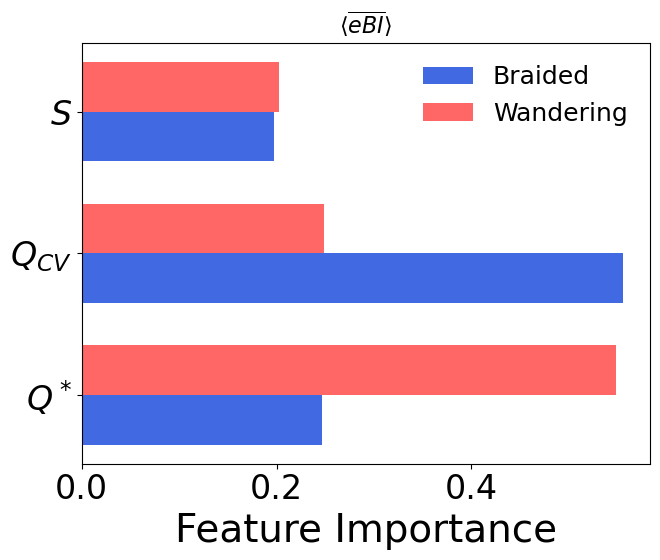


=== Target: T_R ===
Braided   → RMSE: 40.800, R²: -5.428
Wandering → RMSE: 85.233, R²: -0.201


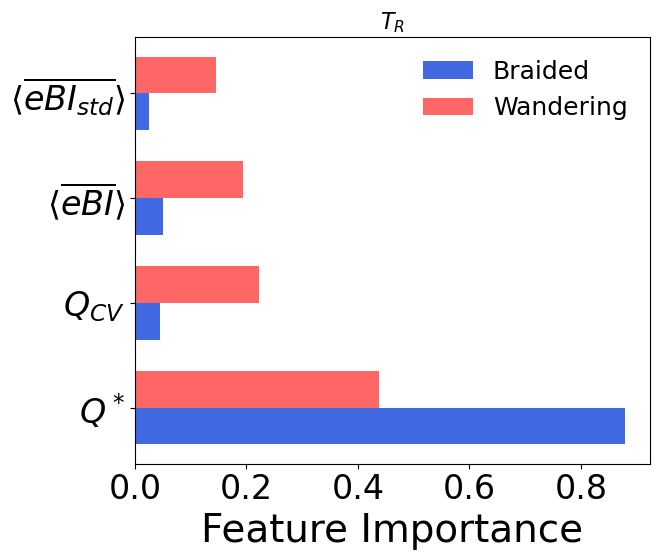


=== Target: CB/Aw ===
Braided   → RMSE: 1.710, R²: -1.131
Wandering → RMSE: 5.429, R²: 0.336


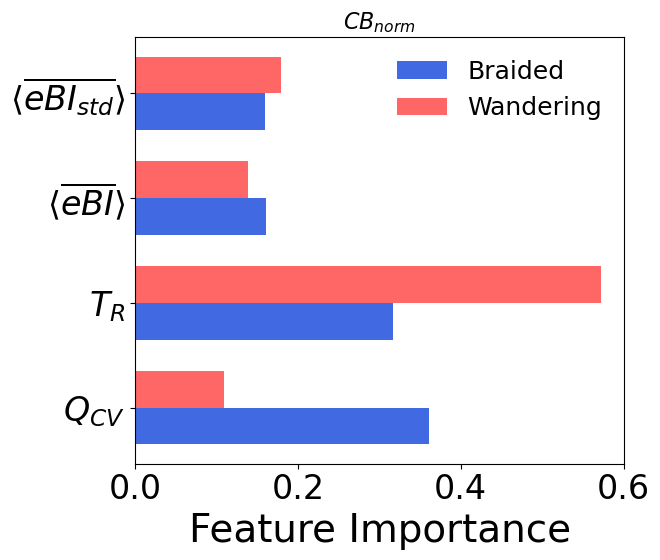


=== Target: eBI_BI_ratio_site ===
Braided   → RMSE: 0.050, R²: 0.687
Wandering → RMSE: 0.066, R²: 0.074


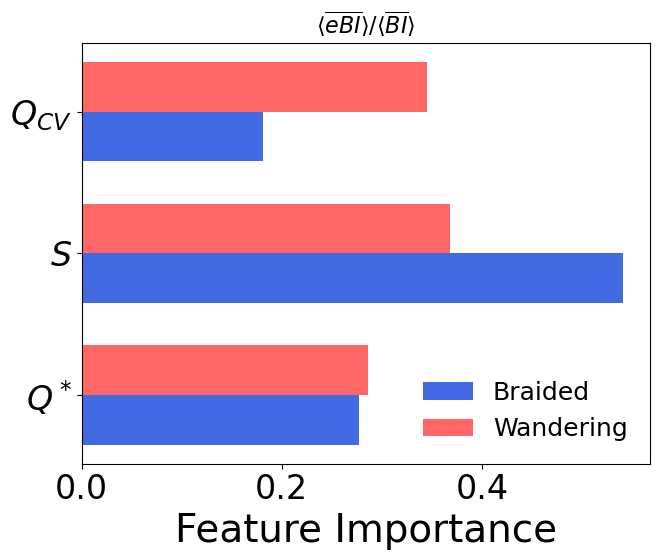

In [22]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1) Load the dataset
csv_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(csv_path)

# 2) Rename slope column
df.rename(columns={'Slope (cm/km) ': 'Slope_cm_per_km'}, inplace=True)

# 3) LaTeX labels
label_map = {
    'dim_Q':               r'$\mathit{Q}^*$',
    'cov_discharge_site':  r'$Q_{CV}$',
    'Slope_cm_per_km':     r'$\mathit{S}$',
    'mean_ebi_site':       r'$\langle\overline{\mathit{eBI}}\rangle$',
    'std_ebi_site':        r'$\langle\overline{\mathit{eBI_{std}}}\rangle$',
    'T_R':                 r'$T_{R}$',
    'CB/Aw':               r'$CB_{norm}$',
    'eBI_BI_ratio_site':   r'$\langle\overline{\mathit{eBI}}\rangle/\langle\overline{\mathit{BI}}\rangle$'
}

# 4) Feature lists per target
features_map = {
    'mean_ebi_site':     ['dim_Q', 'cov_discharge_site', 'Slope_cm_per_km'],
    'T_R':               ['dim_Q', 'cov_discharge_site', 'mean_ebi_site', 'std_ebi_site'],
    'CB/Aw':             ['cov_discharge_site', 'T_R', 'mean_ebi_site', 'std_ebi_site'],
    'eBI_BI_ratio_site': ['dim_Q', 'Slope_cm_per_km', 'cov_discharge_site']
}

# 5) Split by river type
df_braided   = df[df['Classification'] == 'B']
df_wandering = df[df['Classification'].isin(['LSW','HSW'])]

outdir = r"C:\Users\Feifei\Box\BR_remote_sensing\figures"
os.makedirs(outdir, exist_ok=True)

# 6) Loop through targets, fit RFs, print metrics, and plot combined bars
for target, feats in features_map.items():
    print(f"\n=== Target: {target} ===")
    # Braided
    data_b = df_braided[feats + [target]].dropna()
    Xb, yb = data_b[feats], data_b[target]
    Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(
        Xb, yb, test_size=0.3, random_state=42
    )
    rf_b = RandomForestRegressor(n_estimators=500, random_state=42)
    rf_b.fit(Xb_tr, yb_tr)
    yb_pred = rf_b.predict(Xb_te)
    rmse_b = mean_squared_error(yb_te, yb_pred, squared=False)
    r2_b   = r2_score(yb_te, yb_pred)
    print(f"Braided   → RMSE: {rmse_b:.3f}, R²: {r2_b:.3f}")

    # Wandering
    data_w = df_wandering[feats + [target]].dropna()
    Xw, yw = data_w[feats], data_w[target]
    Xw_tr, Xw_te, yw_tr, yw_te = train_test_split(
        Xw, yw, test_size=0.3, random_state=42
    )
    rf_w = RandomForestRegressor(n_estimators=500, random_state=42)
    rf_w.fit(Xw_tr, yw_tr)
    yw_pred = rf_w.predict(Xw_te)
    rmse_w = mean_squared_error(yw_te, yw_pred, squared=False)
    r2_w   = r2_score(yw_te, yw_pred)
    print(f"Wandering → RMSE: {rmse_w:.3f}, R²: {r2_w:.3f}")

    # Extract importances
    imps_b = rf_b.feature_importances_
    imps_w = rf_w.feature_importances_

    # Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    y_pos = np.arange(len(feats))
    height = 0.35

    ax.barh(y_pos - height/2, imps_b, height=height, label='Braided',   color='#4169E1')
    ax.barh(y_pos + height/2, imps_w, height=height, label='Wandering', color='#FF6666')

    ax.set_yticks(y_pos)
    ax.set_yticklabels([label_map[f] for f in feats])
    ax.set_xlabel("Feature Importance")
    ax.set_title(label_map[target], fontsize=16)
    ax.legend(frameon=False)

    plt.tight_layout()

    # Save as PDF
    safe_t = re.sub(r'[<>:"/\\|?*]', '_', target)
    fname  = os.path.join(outdir, f"11_{safe_t}_combined.pdf")
    fig.savefig(fname, format='pdf', dpi=500, bbox_inches='tight', transparent=True)
    plt.show()



In [2]:

# 1) Load the dataset
csv_path = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"
df = pd.read_csv(csv_path)

# 2) Rename slope column
df.rename(columns={'Slope (cm/km) ': 'Slope_cm_per_km'}, inplace=True)

# 3) LaTeX labels (for any future plotting)
label_map = {
    'dim_Q':               r'$\mathit{Q}^*$',
    'cov_discharge_site':  r'$Q_{CV}$',
    'Slope_cm_per_km':     r'$\mathit{S}$',
    'mean_ebi_site':       r'$\langle\overline{\mathit{eBI}}\rangle$',
    'std_ebi_site':        r'$\langle\overline{\mathit{eBI_{std}}}\rangle$',
    'T_R':                 r'$T_{R}$',
    'CB/Aw':               r'$CB_{norm}$',
    'eBI_BI_ratio_site':   r'$\langle\overline{\mathit{eBI}}\rangle/\langle\overline{\mathit{BI}}\rangle$'
}

# 4) Feature lists per target
features_map = {
    'mean_ebi_site':     ['dim_Q', 'cov_discharge_site', 'Slope_cm_per_km'],
    'T_R':               ['dim_Q', 'cov_discharge_site', 'mean_ebi_site', 'std_ebi_site'],
    'CB/Aw':             ['dim_Q', 'cov_discharge_site', 'T_R', 'mean_ebi_site', 'std_ebi_site'],
    'eBI_BI_ratio_site': ['dim_Q', 'Slope_cm_per_km', 'cov_discharge_site']
}

# 5) Loop through each target, train on the full dataset (no braided/wandering split),
#    and print RMSE & R² for each individual predictor

for target, feats in features_map.items():
    print(f"\n=== Predicting '{target}' ===")
    # drop rows with any missing in this target+its predictors
    data = df[feats + [target]].dropna()
    X, y = data[feats], data[target]

    # single 70/30 train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # loop over each predictor column
    for feat in feats:
        rf = RandomForestRegressor(n_estimators=500, random_state=42)
        rf.fit(X_train[[feat]], y_train)
        y_pred = rf.predict(X_test[[feat]])

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2   = r2_score(y_test, y_pred)
        print(f"{feat:20s} → RMSE: {rmse:.3f}, R²: {r2:.3f}")




=== Predicting 'mean_ebi_site' ===
dim_Q                → RMSE: 1.566, R²: -0.720
cov_discharge_site   → RMSE: 0.849, R²: 0.495
Slope_cm_per_km      → RMSE: 1.302, R²: -0.189

=== Predicting 'T_R' ===
dim_Q                → RMSE: 70.901, R²: -0.293
cov_discharge_site   → RMSE: 83.039, R²: -0.773
mean_ebi_site        → RMSE: 66.761, R²: -0.146
std_ebi_site         → RMSE: 78.371, R²: -0.579

=== Predicting 'CB/Aw' ===
dim_Q                → RMSE: 7.762, R²: -1.043
cov_discharge_site   → RMSE: 4.756, R²: 0.233
T_R                  → RMSE: 5.265, R²: 0.060
mean_ebi_site        → RMSE: 6.480, R²: -0.424
std_ebi_site         → RMSE: 5.856, R²: -0.163

=== Predicting 'eBI_BI_ratio_site' ===
dim_Q                → RMSE: 0.073, R²: -0.002
Slope_cm_per_km      → RMSE: 0.067, R²: 0.156
cov_discharge_site   → RMSE: 0.071, R²: 0.073
